In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms

import os
import sys

sys.path.append("../scripts")
from data import get_sample_patches_dataset, get_filenames
from models import SmallAutoEncoder, AutoEncoder, DEC

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load data
filenames = get_filenames()[:50000]
dataset_small = get_sample_patches_dataset(filenames=filenames, resize=(28, 28))
dataset_big =  get_sample_patches_dataset(filenames=filenames, resize=(224, 224), resnet = True)
dl_small = torch.utils.data.DataLoader(dataset_small, batch_size=64)
dl_big = torch.utils.data.DataLoader(dataset_big, batch_size=64)

In [40]:
def get_sample_from_batch(batch, i = 0):
    j = 0
    for b, _ in batch:
        j += b.shape[0]
        if j > i:
            return b[i % b.shape[0]]
        
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

def plot_sample(sample, resnet = False, ax = None):

    img = sample
    if resnet:
        img = inv_normalize(img)
    img = img.permute(1, 2, 0).numpy()
    if ax is None:
        plt.imshow(img)
        plt.axis(False)
        plt.show()
    else:
        ax.imshow(img)

/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


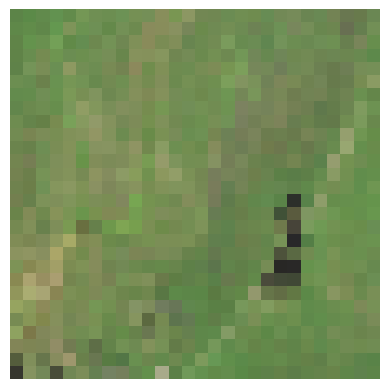

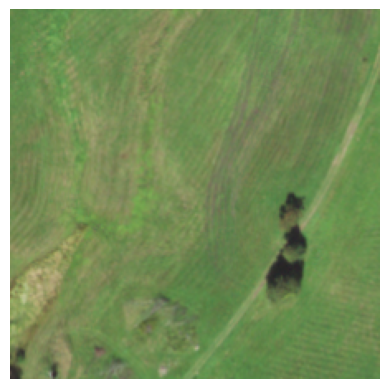

In [41]:
plot_sample(get_sample_from_batch(dl_small, 100))
plot_sample(get_sample_from_batch(dl_big, 100), True)

In [36]:
# load only resnet and cluster with that
model = {}
latent_dim = 50
model['dec_medium'] = SmallAutoEncoder(latent_dim, layers_per_block=4)
model['dec_medium'] = DEC(10, latent_dim, model['dec_medium'].encoder)
model['dec_medium'].load_state_dict(torch.load("../models/DEC_medium/model.pt"))
latent_dim = 20
model["dec_resnet50"] = AutoEncoder(latent_dim, encoder_arch="resnet50", decoder_layers_per_block=[3] * 5)
model["dec_resnet50"] = DEC(10, latent_dim, model['dec_resnet50'].encoder)
model["dec_resnet50"].load_state_dict(torch.load("../models/DEC_resnet50/model.pt"))
model['resnet50'] = list(AutoEncoder(latent_dim = latent_dim, encoder_arch = "resnet50").encoder.children())[0][:-10]
for m in model.values():
    m.eval()
    m.to(device)

In [37]:
embeddings = {}
for key in model.keys():
    embeddings[key] = []
for batch, _ in dl_small:
    batch_size = batch.shape[0]
    batch = batch.to(device)
    embeddings["dec_medium"].append(model["dec_medium"](batch).max(1)[1].detach().cpu().numpy().reshape(batch_size, -1))

for batch, _ in dl_big:
    batch_size = batch.shape[0]
    batch = batch.to(device)
    embeddings["dec_resnet50"].append(model["dec_resnet50"](batch).max(1)[1].detach().cpu().numpy().reshape(batch_size, -1))
    #embeddings["resnet50"].append(model["resnet50"](batch).detach().cpu().numpy().reshape(batch_size, -1))

embeddings["dec_medium"] = np.concatenate(embeddings["dec_medium"])
embeddings["dec_resnet50"] = np.concatenate(embeddings["dec_resnet50"])
#embeddings["resnet50"] = np.concatenate(embeddings["resnet50"])

clusters = {}
clusters["dec_medium"] = embeddings["dec_medium"]
clusters["dec_resnet50"] = embeddings["dec_resnet50"]

#cls = KMeans(10, n_init=20)
#clusters["resnet50"] = cls.fit_predict(embeddings["resnet50"])


In [ ]:
fig, axs = plt.subplots(nrows = 4, ncols = 3, figsize = (20, 20))
axs = axs.flat
[ax.axis("off") for ax in axs]
name = "resnet50"
for i in range(10):
    samples = clusters[name] == i
    axs[i].set_title(f"Cluster {i}")
    if np.sum(samples) == 0:
        continue
    random_samples = np.random.choice(np.where(samples)[0], 16)
    im = np.zeros((224*4, 224*4, 3))
    for j, idx in enumerate(random_samples):
        im[224*(j//4):224*(j//4+1), 224*(j%4):224*(j%4+1)] = dataset_big[idx][0].permute(1, 2, 0)
    axs[i].imshow(im)
plt.show()

In [44]:
torch.zeros

<function torch._VariableFunctionsClass.zeros>

/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


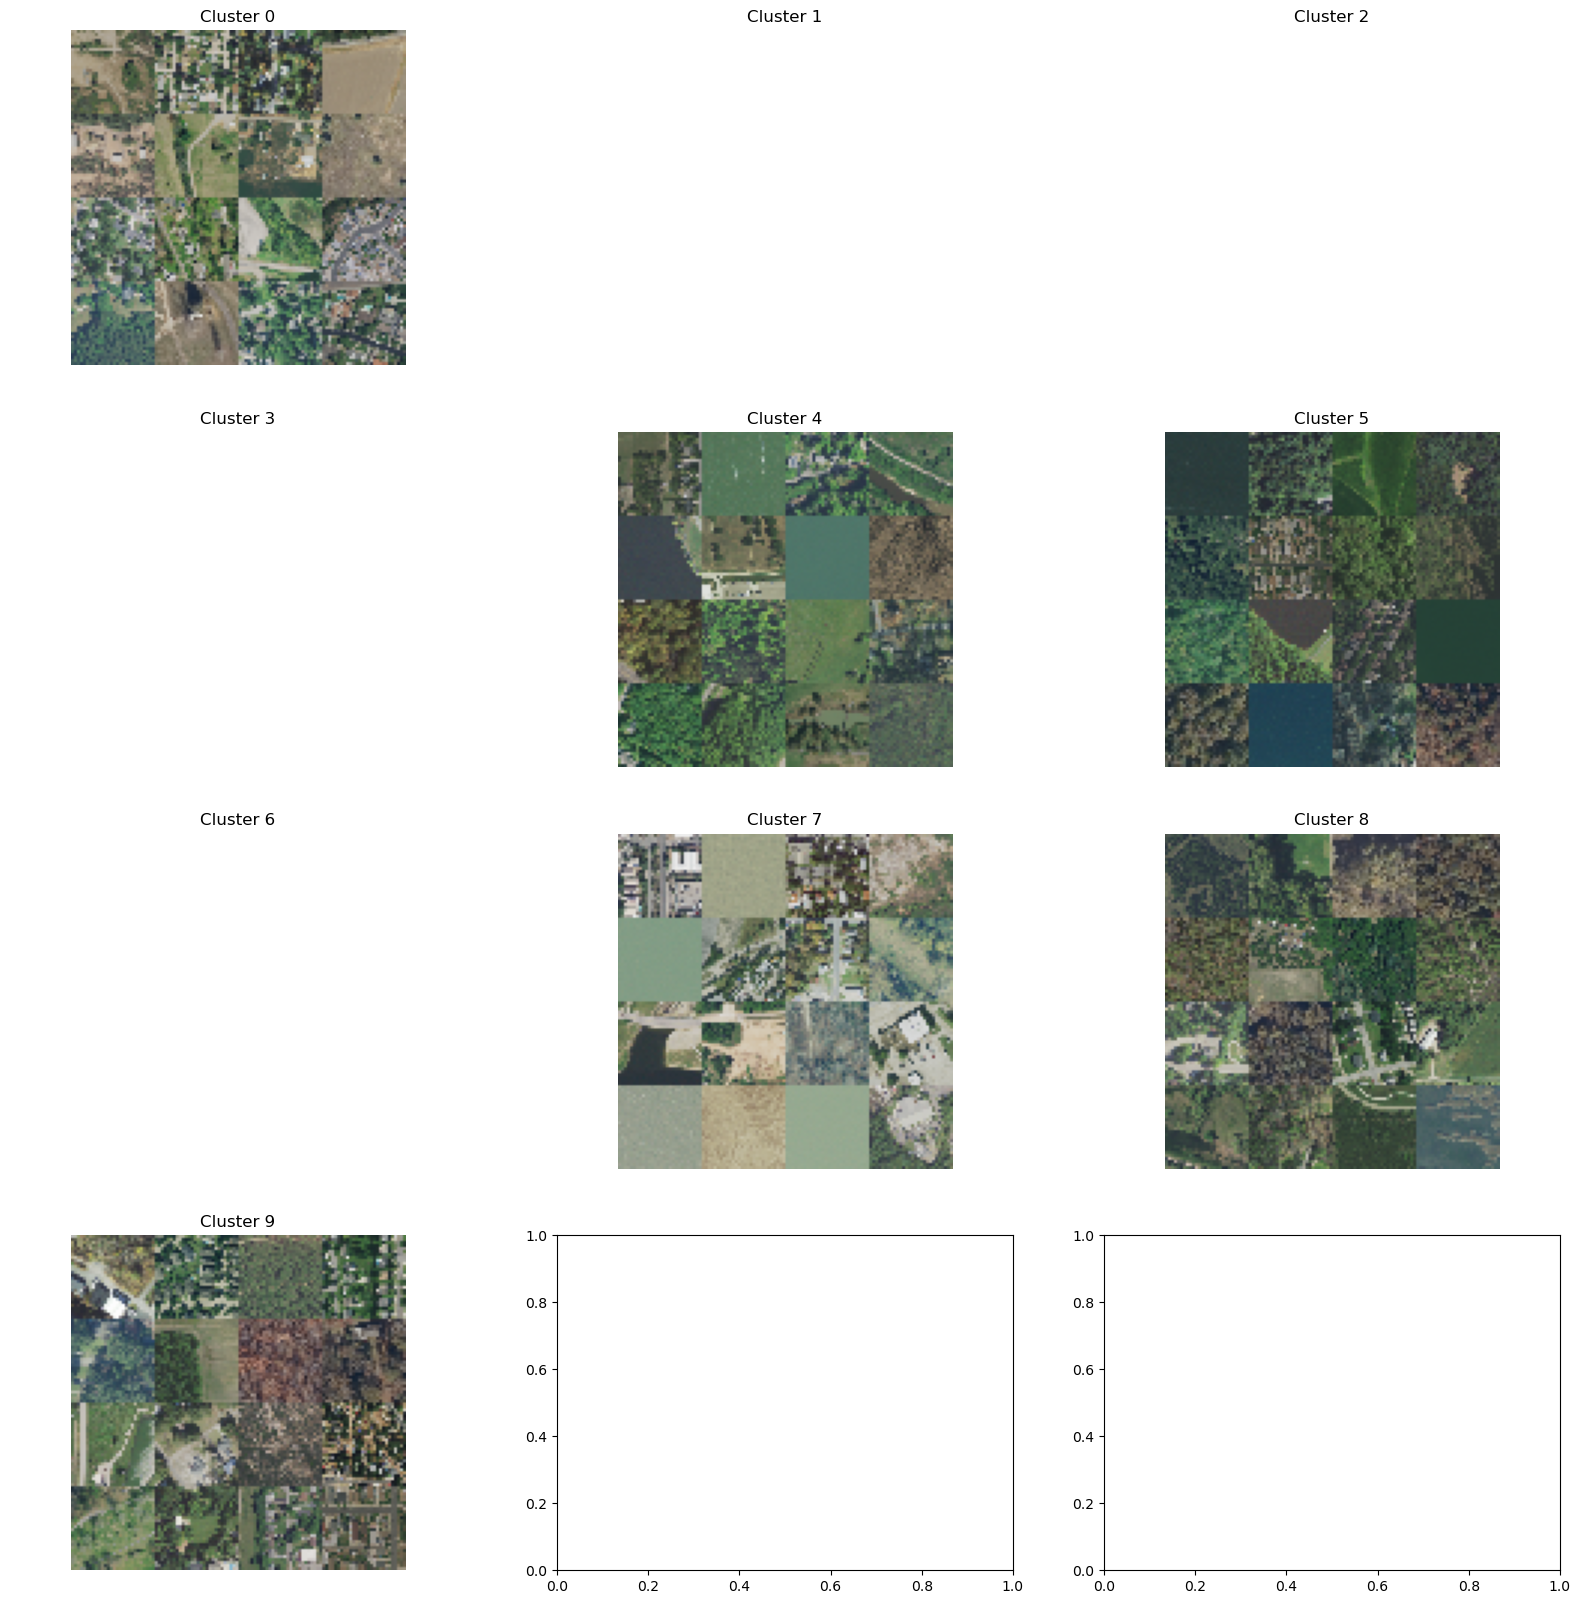

In [45]:
fig, axs = plt.subplots(nrows = 4, ncols = 3, figsize = (20, 20))
axs = axs.flat
name = "dec_medium"
for i in range(10):
    samples = clusters[name] == i
    axs[i].axis("off")
    axs[i].set_title(f"Cluster {i}")
    if np.sum(samples) == 0:
        continue
    random_samples = np.random.choice(np.where(samples)[0], 16)
    im = torch.zeros((3, 28*4, 28*4))
    for j, idx in enumerate(random_samples):
        im[:, 28*(j//4):28*(j//4+1), 28*(j%4):28*(j%4+1)] = dataset_small[idx][0]
    plot_sample(im, ax = axs[i])
    
plt.show()

/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


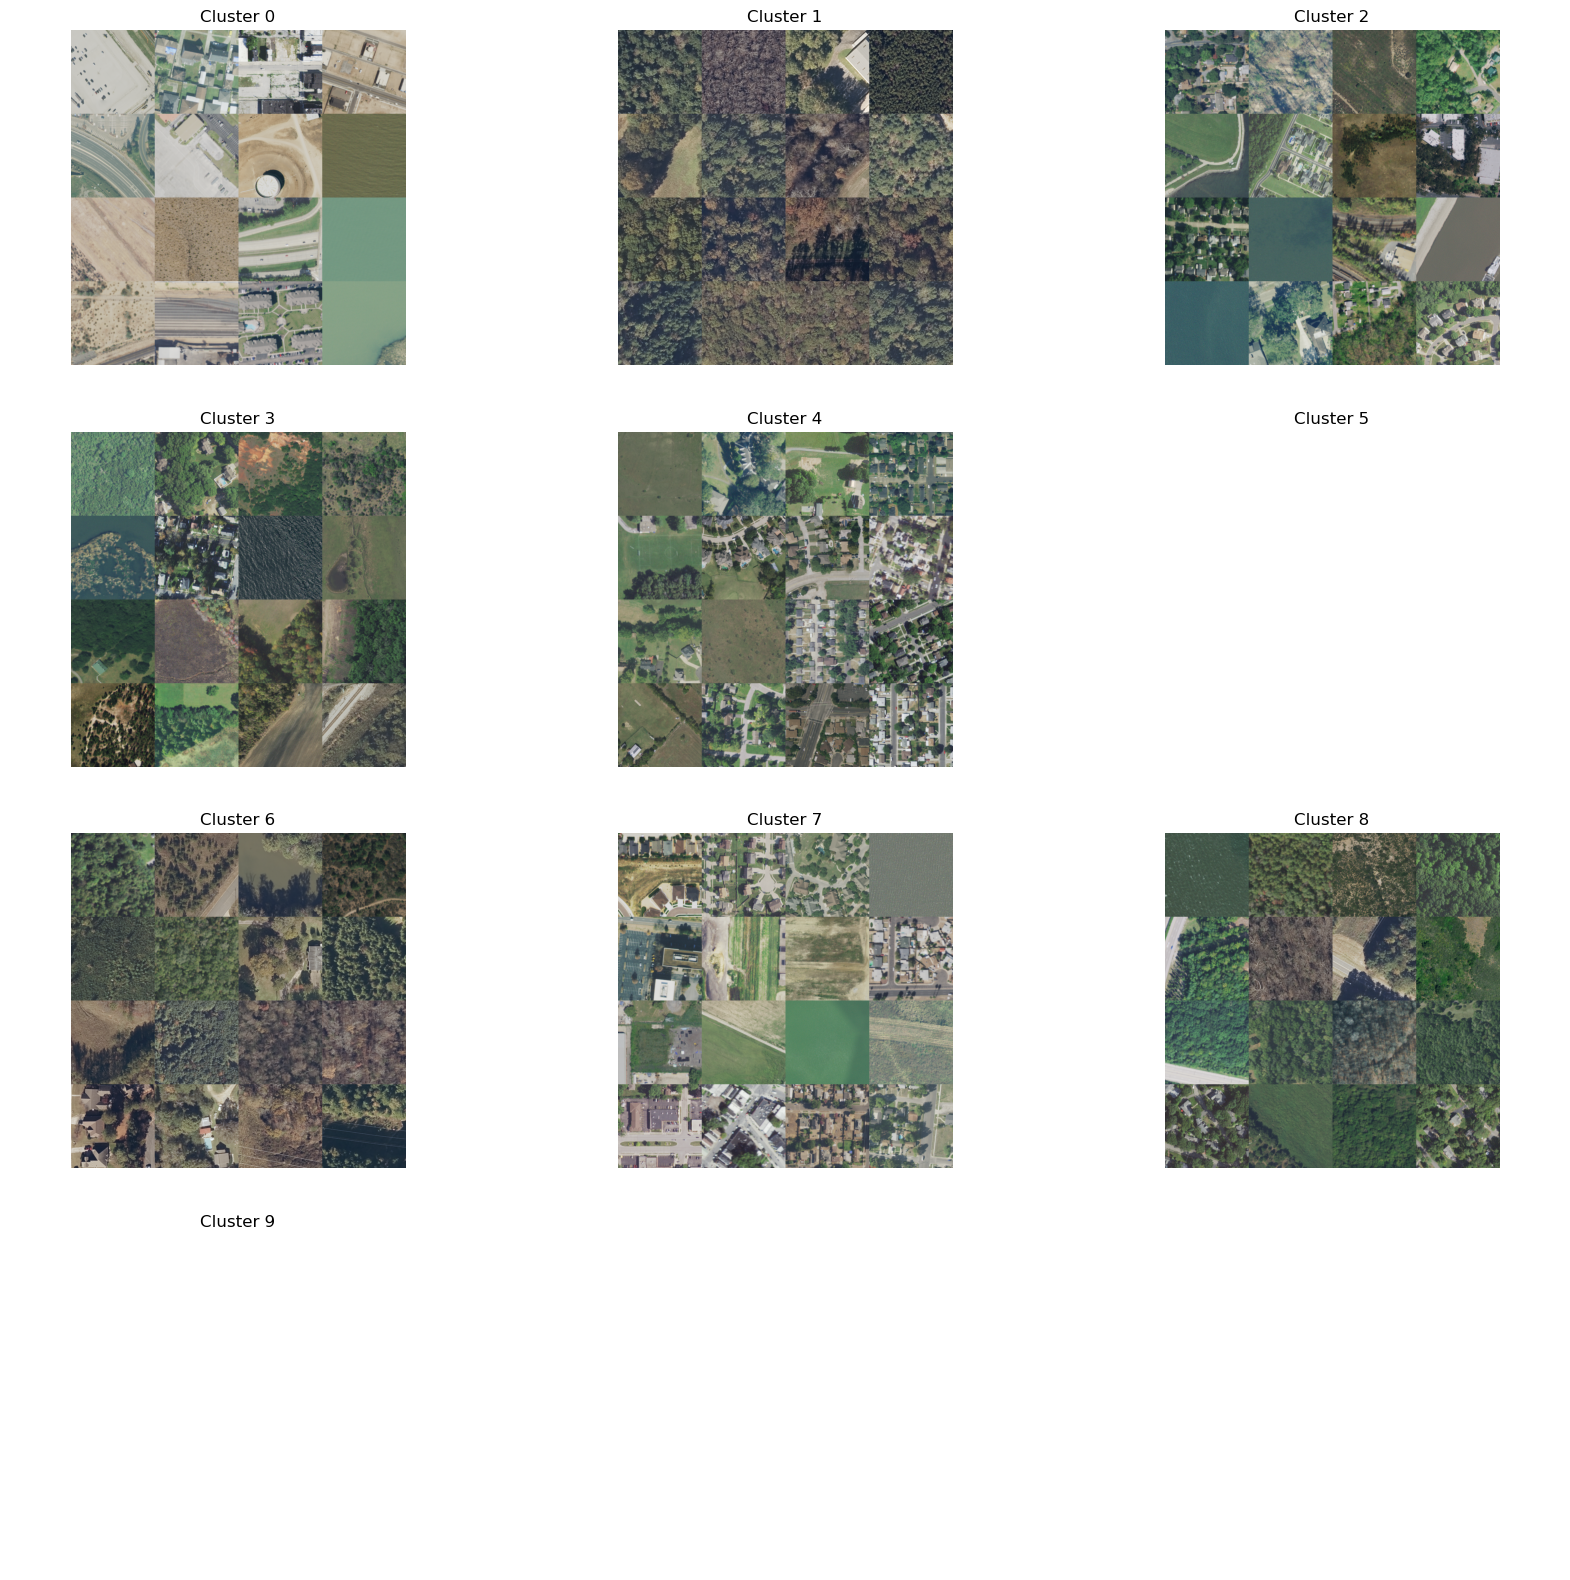

In [46]:
fig, axs = plt.subplots(nrows = 4, ncols = 3, figsize = (20, 20))
axs = axs.flat
[ax.axis("off") for ax in axs]
name = "dec_resnet50"
for i in range(10):
    samples = clusters[name] == i
    axs[i].set_title(f"Cluster {i}")
    if np.sum(samples) == 0:
        continue
    random_samples = np.random.choice(np.where(samples)[0], 16)
    im = torch.zeros((3, 224*4, 224*4))
    for j, idx in enumerate(random_samples):
        im[:, 224*(j//4):224*(j//4+1), 224*(j%4):224*(j%4+1)] = dataset_big[idx][0]
    plot_sample(im, True, axs[i])
    
plt.show()
